In [1]:
from src.ocsmm.OneClassSMMClassifier import OneClassSMMClassifier
import numpy as np
from torch import FloatTensor
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import StandardScaler


In [2]:

def generate_compact_dataset():
    # Set the mean for normal groups (same for all normal groups)
    np.random.seed(20) 
    mean_normal = np.array([0, 0])

    base_cov_normal =  [[1.1, 1], [1, 1]]

    angle_rad = np.radians(90)

    # Create the rotation matrix for 2D
    rotation_matrix = np.array([[np.cos(angle_rad), -np.sin(angle_rad)],
                                [np.sin(angle_rad), np.cos(angle_rad)]])

    # Set the mean for outlier groups (far from the normal groups)
    mean_outlier = np.array([1, 5])

    # Covariance matrix for outliers (wider spread)
    cov_matrix_rot = rotation_matrix @ base_cov_normal @ rotation_matrix.T

    # Generate 18 normal groups with different variances
    normal_groups = []
    for i in range(18):
        data_normal = np.random.multivariate_normal(mean_normal, base_cov_normal, 50)
        normal_groups.append(FloatTensor(data_normal))

    # Generate 2 outlier groups with a different covariance (wider spread)
    outlier_group_1 = np.random.multivariate_normal(mean_outlier, cov_matrix_rot, 50)
    outlier_group_2 = np.random.multivariate_normal(mean_outlier, cov_matrix_rot, 50)

    # Combine all groups
    all_groups = normal_groups + [FloatTensor(outlier_group_1), FloatTensor(outlier_group_2)]

    return all_groups

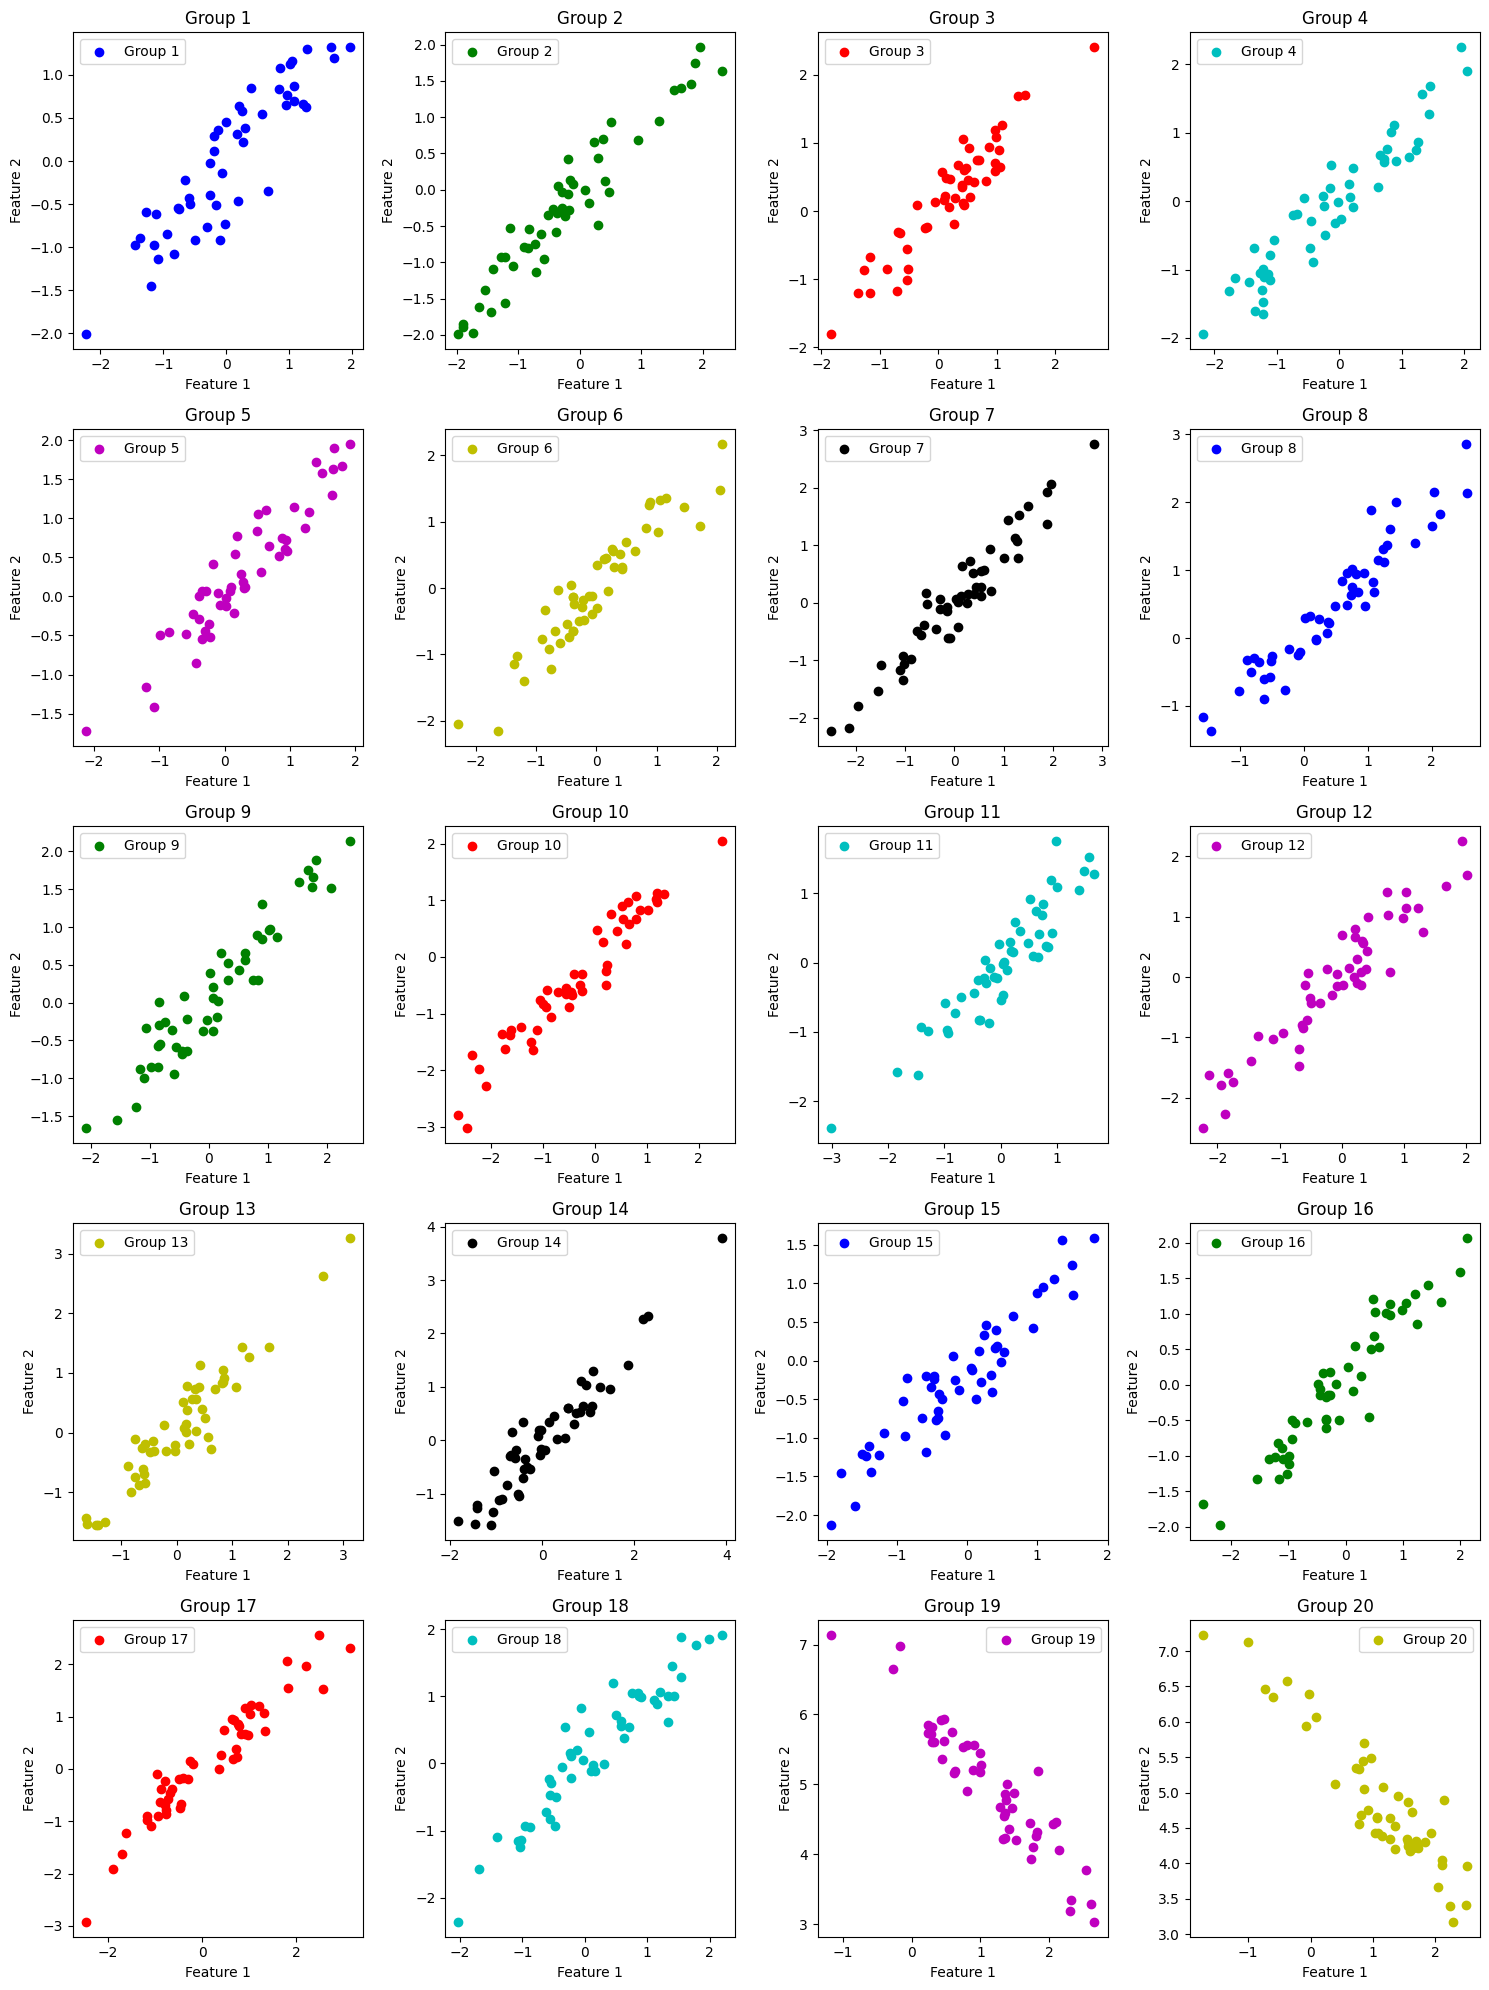

In [3]:
def plot_all_groups_subplots(groups):
    # Create a figure with 5 rows and 4 columns (to fit 20 subplots)
    fig, axes = plt.subplots(5, 4, figsize=(15, 20))
    
    # Flatten axes array to easily index it
    axes = axes.flatten()

    # Different colors for each group
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k'] * 3  # Repeat colors for 20 groups
    
    for idx, (group, ax) in enumerate(zip(groups, axes)):
        ax.scatter(group[:, 0], group[:, 1], color=colors[idx], label=f"Group {idx + 1}")
        ax.set_title(f"Group {idx + 1}")
        ax.set_xlabel("Feature 1")
        ax.set_ylabel("Feature 2")
        ax.legend()

    plt.tight_layout()  # Adjust layout to avoid overlap
    plt.show()

# Generate the dataset
datasets = generate_compact_dataset()

# Plot all groups on different subplots
plot_all_groups_subplots(datasets)

In [4]:
classifier = OneClassSMMClassifier(datasets=datasets, nu=0.2, gamma_x=0.3, gamma_d=0.3)
decision, y_pred = classifier.fit()

20
20
20
5


In [5]:
for i, (score, pred) in enumerate(zip(decision, y_pred)):
    print(f"Group {i+1}: Decision Score = {score:}, Prediction = {pred}")

Group 1: Decision Score = 0.017864661543414595, Prediction = 1.0
Group 2: Decision Score = 0.01482210130987438, Prediction = 1.0
Group 3: Decision Score = -0.011399782373634704, Prediction = -1.0
Group 4: Decision Score = 0.03254331705582825, Prediction = 1.0
Group 5: Decision Score = 0.0, Prediction = 0.0
Group 6: Decision Score = 0.009942347895663506, Prediction = 1.0
Group 7: Decision Score = 0.04663538325524197, Prediction = 1.0
Group 8: Decision Score = 0.02299780141305474, Prediction = 1.0
Group 9: Decision Score = 0.03207918196457893, Prediction = 1.0
Group 10: Decision Score = 0.03034779896636497, Prediction = 1.0
Group 11: Decision Score = 0.004830683911706046, Prediction = 1.0
Group 12: Decision Score = 0.040428890095766334, Prediction = 1.0
Group 13: Decision Score = 0.020360550975282, Prediction = 1.0
Group 14: Decision Score = 0.03501300838375787, Prediction = 1.0
Group 15: Decision Score = -0.002266469695316964, Prediction = -1.0
Group 16: Decision Score = 0.0250037204950

In [6]:
# import itertools
# def grid_search_gamma(datasets, nu=0.1, gamma_x_values=None, gamma_d_values=None):
#     """Performs grid search over gamma_x and gamma_d to find optimal values."""

#     if gamma_x_values is None:
#         gamma_x_values = np.arange(0.1, 1.1, 0.1)  

#     if gamma_d_values is None:
#         gamma_d_values = np.arange(0.1, 1.1, 0.1) 

#     best_params = None
#     best_score = float('inf')  # Initialize with a high number
#     results = []

#     # Iterate over all combinations of gamma_x and gamma_d
#     for gamma_x, gamma_d in itertools.product(gamma_x_values, gamma_d_values):
#         # print(f"Testing gamma_x={gamma_x}, gamma_d={gamma_d}...")

#         # Train One-Class SMM with current parameters
#         classifier = OneClassSMMClassifier(
#             datasets=datasets,
#             nu=nu,
#             gamma_x=gamma_x,
#             gamma_d=gamma_d
#         )

#         # Get predictions
#         decision, predictions = classifier.fit()

#         num_outliers = np.sum(predictions == -1)

#         # Store results only if we have 1, 2, or 3 outliers
#         if num_outliers in {2, 3}:
#             results.append((gamma_x, gamma_d, num_outliers))
#             print(f"gamma_x={gamma_x:.5f}, gamma_d={gamma_d:.5f}, pred19 = {predictions[18]}, pred20={predictions[19]} -> Outliers Detected: {num_outliers}")

#             # If exactly 2 outliers, save as best parameters
#             if num_outliers == 2 and best_params is None:
#                 best_params = (gamma_x, gamma_d)

#     if not results:
#         print("\nNo hyperparameter settings resulted in 1, 2, or 3 outliers.")

#     return best_params, results

# grid_search_gamma(datasets)

In [7]:

counts = {1: np.sum(y_pred == 1), -1: np.sum(y_pred == -1)}
total = len(y_pred)
percentages = {key: (count / total) * 100 for key, count in counts.items()}

results = {key: {"count": counts[key], "percentage": percentages[key]} for key in counts}

print(results)

{1: {'count': 15, 'percentage': 75.0}, -1: {'count': 4, 'percentage': 20.0}}


In [8]:
datasets_tensor = torch.stack(datasets)

In [9]:
from src.explanation_algorithms.OCSMMSHAP import OCSMMSHAP
ocsmm_shap = OCSMMSHAP(X=datasets_tensor, classifier=classifier)
ocsmm_shap.fit_ocsmmshap(X=datasets_tensor, num_coalitions=2**datasets_tensor[0].shape[1])

20
20
20
5


/Users/swathisuhas/Documents/CISPA/OCSVM-SHAP/OCSVM_SHAP/src/utils/shapley_procedure/coalitions.py:19: RuntimeWarning: divide by zero encountered in log2
  set_to_1 = np.floor(np.log2(rest)).astype(int)
/Users/swathisuhas/Documents/CISPA/OCSVM-SHAP/OCSVM_SHAP/src/utils/shapley_procedure/coalitions.py:19: RuntimeWarning: invalid value encountered in cast
  set_to_1 = np.floor(np.log2(rest)).astype(int)
/Users/swathisuhas/Documents/CISPA/OCSVM-SHAP/OCSVM_SHAP/src/utils/shapley_procedure/coalitions.py:19: RuntimeWarning: invalid value encountered in log2
  set_to_1 = np.floor(np.log2(rest)).astype(int)
100%|██████████| 3/3 [00:00<00:00, 363.58it/s]


20
20
20
20
20
20
20
20
20
20
20
20


RuntimeError: einsum(): subscript j has size 1000 for operand 1 which does not broadcast with previously seen size 20

## Experiment 2

I have 10 groups, each with 100 points. There are two features. All features are between values of 5 and 10. For one group, we will make all values of first feature between 100 and 120. For the second group, we make all values of second feature between 100 and 120. 
Both of these groups should be identified as outliers. 

In [ ]:
def generate_groups():
    # Normal groups (8 groups with normal data)
    normal_groups = []
    for _ in range(8):
        group = np.random.uniform(5, 10, size=(10, 2))  # 100 points, 2 features between 5 and 10
        normal_groups.append(torch.FloatTensor(group))
    
    # Outlier Group 1: Modify first feature to be between 100 and 120
    outlier_group_1 = np.random.uniform(5, 10, size=(10, 1))  # Second feature between 5 and 10
    outlier_group_1 = np.hstack([np.random.uniform(100, 120, size=(10, 1)), outlier_group_1])  # First feature between 100 and 120
    
    # Outlier Group 2: Modify second feature to be between 100 and 120
    outlier_group_2 = np.random.uniform(5, 10, size=(10, 1))  # First feature between 5 and 10
    outlier_group_2 = np.hstack([outlier_group_2, np.random.uniform(100, 120, size=(10, 1))])  # Second feature between 100 and 120
    
    outlier_group_1 = torch.FloatTensor(outlier_group_1)
    outlier_group_2 = torch.FloatTensor(outlier_group_2)
    
    # Combine all groups (8 normal groups + 2 outliers)
    all_groups = [outlier_group_1, outlier_group_2] + normal_groups 
    return all_groups

In [ ]:
groups = generate_groups()
groups

[tensor([[100.4243,   5.7591],
         [108.0884,   8.9871],
         [107.1056,   8.3496],
         [115.8104,   7.3981],
         [105.7701,   8.5023],
         [112.0944,   7.6856],
         [116.6484,   6.1167],
         [102.7659,   7.1221],
         [116.1183,   6.6563],
         [114.5187,   9.4946]]),
 tensor([[  6.4190, 110.8889],
         [  9.0651, 103.8066],
         [  7.7864, 102.7752],
         [  9.0936, 112.7834],
         [  8.5422, 114.8178],
         [  5.4415, 118.6433],
         [  6.8980, 106.4026],
         [  9.5982, 117.1941],
         [  5.0739, 100.7998],
         [  7.1231, 105.3253]]),
 tensor([[6.8918, 8.9987],
         [7.5711, 6.4231],
         [8.1721, 7.5894],
         [9.6248, 5.6113],
         [5.1117, 8.9491],
         [8.7567, 6.1401],
         [7.1600, 8.9589],
         [6.1767, 9.0074],
         [5.9297, 7.8360],
         [7.1378, 7.0195]]),
 tensor([[8.0018, 6.6694],
         [9.4415, 6.5015],
         [7.6113, 8.4878],
         [5.7411, 6.021

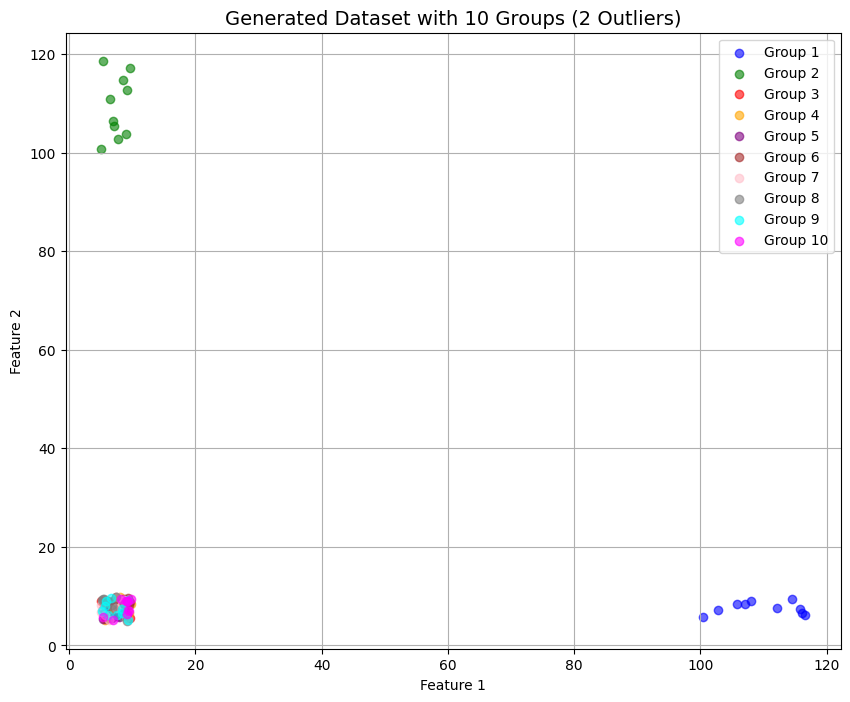

In [ ]:
plt.figure(figsize=(10, 8))

colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta']
for i, group in enumerate(groups):
    plt.scatter(group[:, 0], group[:, 1], color=colors[i], label=f'Group {i+1}', alpha=0.6)

plt.title("Generated Dataset with 10 Groups (2 Outliers)", fontsize=14)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
classifier = OneClassSMMClassifier(groups, nu=0.1,gamma_x=0.1, gamma_d=0.1)

In [ ]:
decision, y_pred = classifier.fit()

In [ ]:
for i, (score, pred) in enumerate(zip(decision, y_pred)):
    print(f"Group {i+1}: Decision Score = {score:}, Prediction = {pred}")

Group 1: Decision Score = -3.845257771084576e-07, Prediction = -1.0
Group 2: Decision Score = -4.010120685515872e-07, Prediction = -1.0
Group 3: Decision Score = 6.937247915006495e-07, Prediction = 1.0
Group 4: Decision Score = 0.007469160586758727, Prediction = 1.0
Group 5: Decision Score = -6.792570034219736e-07, Prediction = -1.0
Group 6: Decision Score = -6.890647583635001e-07, Prediction = -1.0
Group 7: Decision Score = 0.010118746213064744, Prediction = 1.0
Group 8: Decision Score = 0.0, Prediction = 0.0
Group 9: Decision Score = 0.007052323003227334, Prediction = 1.0
Group 10: Decision Score = 0.004205843614958349, Prediction = 1.0


In [ ]:
import itertools
def grid_search_gamma(datasets, nu=0.1, gamma_x_values=None, gamma_d_values=None):
    """Performs grid search over gamma_x and gamma_d to find optimal values."""
    
    if gamma_x_values is None:
        gamma_x_values = np.logspace(-3, 2, 6)  # Range: [0.001, 100]
    
    if gamma_d_values is None:
        gamma_d_values = np.logspace(-3, 2, 6)  # Range: [0.001, 100]

    best_params = None
    best_score = float('inf')  # Initialize with a high number
    results = []

    # Iterate over all combinations of gamma_x and gamma_d
    for gamma_x, gamma_d in itertools.product(gamma_x_values, gamma_d_values):
        # print(f"Testing gamma_x={gamma_x}, gamma_d={gamma_d}...")

        # Train One-Class SMM with current parameters
        classifier = OneClassSMMClassifier(
            datasets=datasets,
            nu=nu,
            gamma_x=gamma_x,
            gamma_d=gamma_d
        )

        # Get predictions
        decision, predictions = classifier.fit()

        num_outliers = np.sum(predictions == -1)

        # Store results only if we have 1, 2, or 3 outliers
        if num_outliers in {1, 2, 3}:
            results.append((gamma_x, gamma_d, num_outliers))
            print(f"gamma_x={gamma_x:.5f}, gamma_d={gamma_d:.5f}, group1={predictions[0]}, group2={predictions[1]} -> Outliers Detected: {num_outliers}")

            # If exactly 2 outliers, save as best parameters
            if num_outliers == 2 and best_params is None:
                best_params = (gamma_x, gamma_d)

    if not results:
        print("\nNo hyperparameter settings resulted in 1, 2, or 3 outliers.")

    return best_params, results

grid_search_gamma(datasets)

gamma_x=0.00100, gamma_d=0.00100, group1=1.0, group2=0.0 -> Outliers Detected: 3
gamma_x=0.00100, gamma_d=1.00000, group1=1.0, group2=1.0 -> Outliers Detected: 1
gamma_x=0.00100, gamma_d=100.00000, group1=1.0, group2=1.0 -> Outliers Detected: 3
gamma_x=0.01000, gamma_d=0.10000, group1=1.0, group2=1.0 -> Outliers Detected: 1
gamma_x=0.01000, gamma_d=10.00000, group1=1.0, group2=1.0 -> Outliers Detected: 3
gamma_x=0.10000, gamma_d=1.00000, group1=1.0, group2=1.0 -> Outliers Detected: 1
gamma_x=1.00000, gamma_d=1.00000, group1=1.0, group2=1.0 -> Outliers Detected: 1


(None,
 [(0.001, 0.001, 3),
  (0.001, 1.0, 1),
  (0.001, 100.0, 3),
  (0.01, 0.1, 1),
  (0.01, 10.0, 3),
  (0.1, 1.0, 1),
  (1.0, 1.0, 1)])